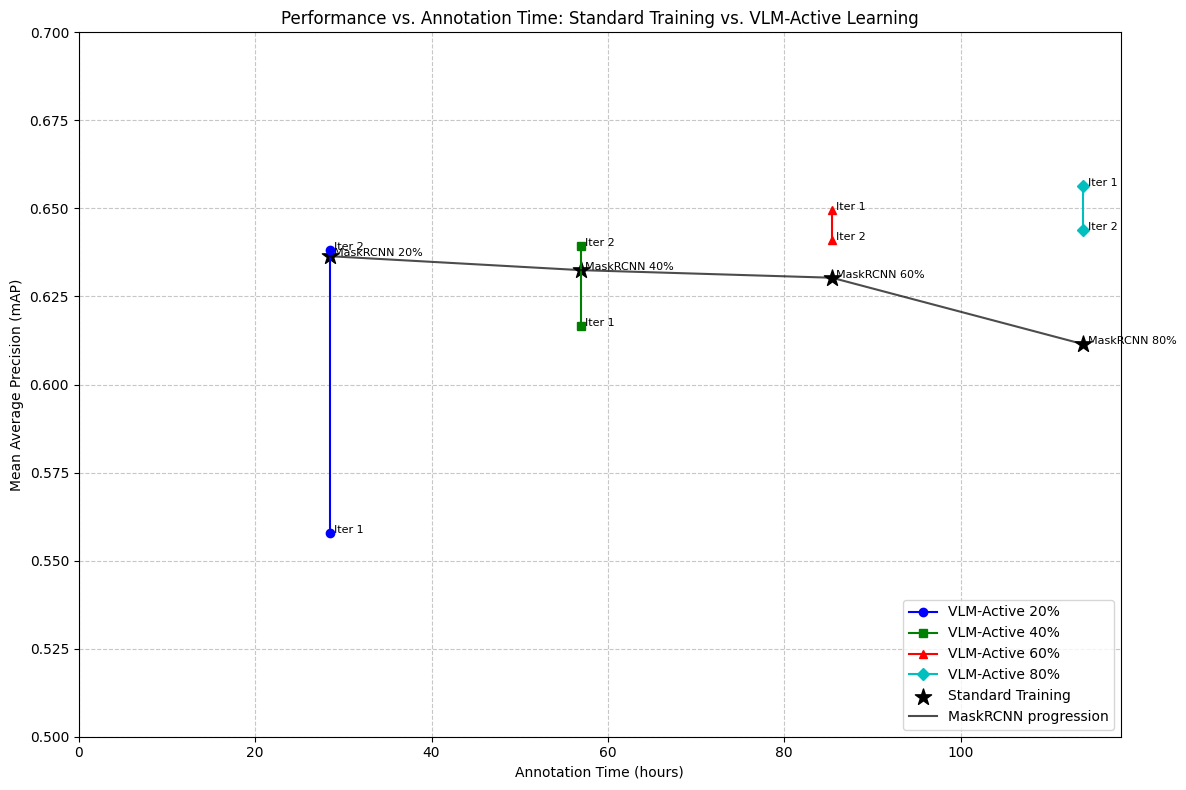

Annotation Time (hours) vs. mAP:

Standard Training:
MaskRCNN 20%: 28.4 hours → 0.6364 mAP
MaskRCNN 40%: 57.0 hours → 0.6325 mAP
MaskRCNN 60%: 85.4 hours → 0.6303 mAP
MaskRCNN 80%: 113.9 hours → 0.6115 mAP

VLM-Active Learning:

proportion_0.20:
  Base annotation time: 28.4 hours
  Iteration 1: 0.5579 mAP
  Iteration 2: 0.6381 mAP

proportion_0.40:
  Base annotation time: 57.0 hours
  Iteration 1: 0.6166 mAP
  Iteration 2: 0.6393 mAP

proportion_0.60:
  Base annotation time: 85.4 hours
  Iteration 1: 0.6496 mAP
  Iteration 2: 0.6410 mAP

proportion_0.80:
  Base annotation time: 113.9 hours
  Iteration 1: 0.6562 mAP
  Iteration 2: 0.6440 mAP


In [2]:
import matplotlib.pyplot as plt
import json
import numpy as np

# Load experiment results
with open("maskrcnn_experiment_results.json") as f:
    maskrcnn_results = json.load(f)

with open("output_proportion_vlm_runs/proportions_exp_20250501_120307/experiment_summary.json") as f:
    active_learning_results = json.load(f)

# Dataset constants from statistics
TOTAL_TRAIN_IMAGES = 2792
AVG_INSTANCES_PER_IMAGE = 2.55
HUMAN_ANNOTATION_TIME = 80  # seconds per instance
BINARY_FEEDBACK_TIME = 3    # seconds per instance

# Set up the figure
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y']
markers = ['o', 's', '^', 'D', 'v']

# Process standard MaskRCNN results (one point per proportion)
maskrcnn_times = []
maskrcnn_maps = []
maskrcnn_labels = []

for i, prop in enumerate(maskrcnn_results["train_proportion"]):
    train_size = maskrcnn_results["train_size"][i]
    map_score = maskrcnn_results["mean_ap"][i]
    
    # Time calculation: initial annotation time
    time_hours = (train_size * AVG_INSTANCES_PER_IMAGE * HUMAN_ANNOTATION_TIME) / 3600  # convert to hours
    
    maskrcnn_times.append(time_hours)
    maskrcnn_maps.append(map_score)
    maskrcnn_labels.append(f"MaskRCNN {prop*100:.0f}%")

# Process active learning results (multiple iterations at same time point)
for i, (prop_key, results) in enumerate(active_learning_results.items()):
    prop = float(prop_key.split('_')[1])
    
    # Get initial training size and calculate time
    initial_train_size = results["train_size"][0]
    time_hours = (initial_train_size * AVG_INSTANCES_PER_IMAGE * HUMAN_ANNOTATION_TIME) / 3600
    
    # Plot all iterations at the same time point (vertical line)
    iterations = results["iteration"]
    map_scores = results["mean_ap"]
    
    plt.plot([time_hours] * len(iterations), map_scores, 
             marker=markers[i % len(markers)], 
             linestyle='-', 
             color=colors[i % len(colors)],
             label=f"VLM-Active {prop*100:.0f}%")
    
    # Add text annotations for each iteration
    for j, (iter_num, map_score) in enumerate(zip(iterations, map_scores)):
        plt.text(time_hours + 0.5, map_score, f"Iter {iter_num}", fontsize=8)

# Plot standard MaskRCNN points
plt.scatter(maskrcnn_times, maskrcnn_maps, marker='*', s=150, color='black', label="Standard Training")
for i, (time, map_score, label) in enumerate(zip(maskrcnn_times, maskrcnn_maps, maskrcnn_labels)):
    plt.text(time + 0.5, map_score, label, fontsize=8)

# Add this code after plotting the individual MaskRCNN scatter points:

# Sort MaskRCNN points by time (to ensure proper line order if data isn't already sorted)
sorted_indices = np.argsort(maskrcnn_times)
sorted_times = [maskrcnn_times[i] for i in sorted_indices]
sorted_maps = [maskrcnn_maps[i] for i in sorted_indices]

# Add a line connecting the MaskRCNN points
plt.plot(sorted_times, sorted_maps, 
         linestyle='-', 
         color='black',
         alpha=0.7,
         label="MaskRCNN progression")

# Update the legend to avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
    elif label == "MaskRCNN progression":  # Keep this one and remove the single point label
        unique_labels[unique_labels.index("Standard Training")] = "MaskRCNN progression"
        unique_handles[unique_labels.index("MaskRCNN progression")] = handle

plt.legend(unique_handles, unique_labels, loc='lower right')

# Format plot
plt.xlabel('Annotation Time (hours)')
plt.ylabel('Mean Average Precision (mAP)')
plt.title('Performance vs. Annotation Time: Standard Training vs. VLM-Active Learning')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

# Set reasonable axis limits
plt.xlim(left=0)
plt.ylim(0.5, 0.7)

plt.tight_layout()
plt.savefig('performance_vs_time_comparison.png', dpi=300)
plt.show()

# Print numeric analysis
print("Annotation Time (hours) vs. mAP:")
print("\nStandard Training:")
for time, map_score, label in zip(maskrcnn_times, maskrcnn_maps, maskrcnn_labels):
    print(f"{label}: {time:.1f} hours → {map_score:.4f} mAP")

print("\nVLM-Active Learning:")
for prop_key, results in active_learning_results.items():
    initial_train_size = results["train_size"][0]
    time_hours = (initial_train_size * AVG_INSTANCES_PER_IMAGE * HUMAN_ANNOTATION_TIME) / 3600
    
    print(f"\n{prop_key}:")
    print(f"  Base annotation time: {time_hours:.1f} hours")
    
    for iter_num, map_score in zip(results["iteration"], results["mean_ap"]):
        print(f"  Iteration {iter_num}: {map_score:.4f} mAP")

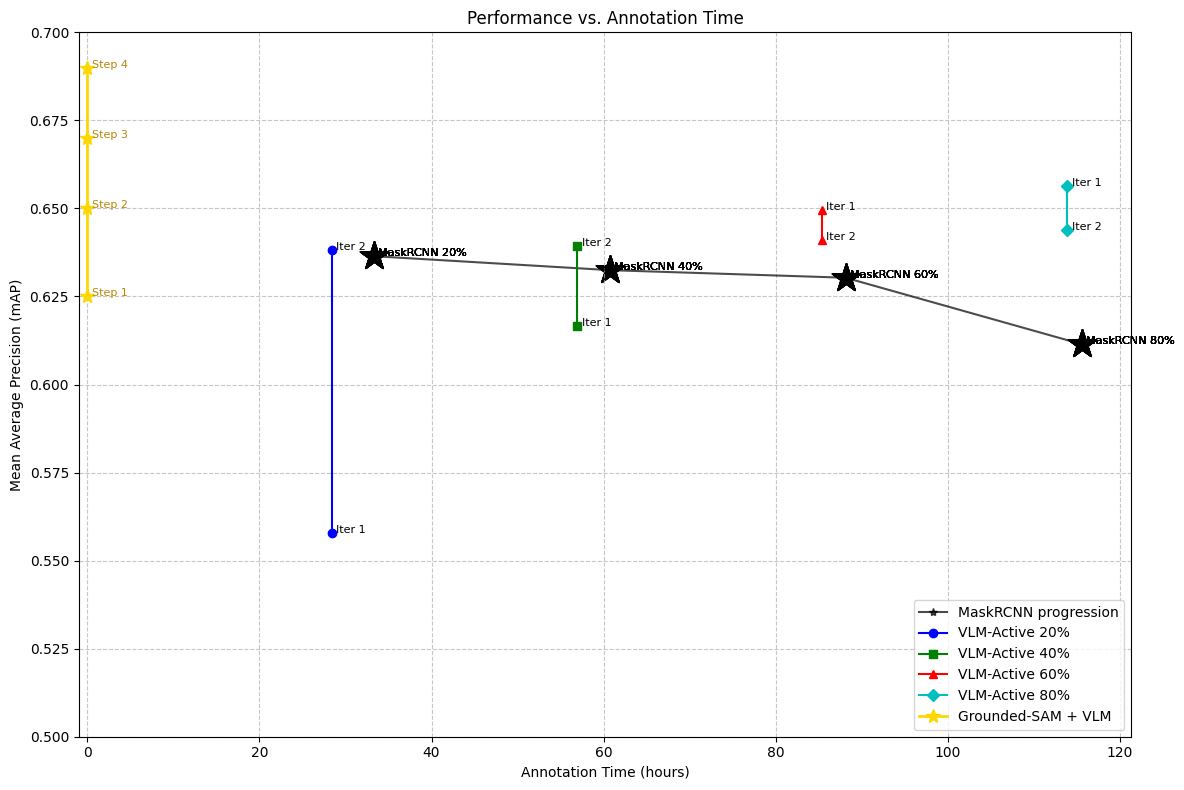

In [ ]:
# Create a new figure with all the existing content plus the hypothetical experiment
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y']
markers = ['o', 's', '^', 'D', 'v']

sorted_props_idx = np.argsort(maskrcnn_results["train_proportion"])
sorted_props = [maskrcnn_results["train_proportion"][i] for i in sorted_props_idx]
sorted_sizes = [maskrcnn_results["train_size"][i] for i in sorted_props_idx]
sorted_maps = [maskrcnn_results["mean_ap"][i] for i in sorted_props_idx]

# Process standard MaskRCNN results (one point per proportion)
# Calculate times properly for each proportion
for i, prop in enumerate(sorted_props):
    train_size = sorted_sizes[i]
    map_score = sorted_maps[i]
    
    # Full annotation time for training images
    annotation_time = (train_size * AVG_INSTANCES_PER_IMAGE * HUMAN_ANNOTATION_TIME) / 3600
    
    # Binary feedback time for inference set (remaining images)
    inference_set_size = TOTAL_TRAIN_IMAGES - train_size
    binary_time = (inference_set_size * AVG_INSTANCES_PER_IMAGE * BINARY_FEEDBACK_TIME) / 3600
    
    # Total time is annotation + binary feedback
    time_hours = annotation_time + binary_time
    
    maskrcnn_times.append(time_hours)
    maskrcnn_maps.append(map_score)
    maskrcnn_labels.append(f"MaskRCNN {prop*100:.0f}%")
# Plot standard MaskRCNN points
plt.scatter(maskrcnn_times, maskrcnn_maps, marker='*',  s=150, color='black')

# Connect MaskRCNN points with a line
sorted_indices = np.argsort(maskrcnn_times)
sorted_times = [maskrcnn_times[i] for i in sorted_indices]
sorted_maps = [maskrcnn_maps[i] for i in sorted_indices]
plt.plot(sorted_times, sorted_maps, linestyle='-', marker='*',  color='black', alpha=0.7, label="MaskRCNN progression")

# Process active learning results (multiple iterations at same time point)
for i, (prop_key, results) in enumerate(active_learning_results.items()):
    prop = float(prop_key.split('_')[1])
    
    # Get initial training size and calculate time
    initial_train_size = results["train_size"][0]
    time_hours = (initial_train_size * AVG_INSTANCES_PER_IMAGE * HUMAN_ANNOTATION_TIME) / 3600
    
    # Plot all iterations at the same time point (vertical line)
    iterations = results["iteration"]
    map_scores = results["mean_ap"]
    
    plt.plot([time_hours] * len(iterations), map_scores, 
             marker=markers[i % len(markers)], 
             linestyle='-', 
             color=colors[i % len(colors)],
             label=f"VLM-Active {prop*100:.0f}%")
    
    # Add text annotations for each iteration
    for j, (iter_num, map_score) in enumerate(zip(iterations, map_scores)):
        plt.text(time_hours + 0.5, map_score, f"Iter {iter_num}", fontsize=8)

# Add text annotations for MaskRCNN points
for i, (time, map_score, label) in enumerate(zip(maskrcnn_times, maskrcnn_maps, maskrcnn_labels)):
    plt.text(time + 0.5, map_score, label, fontsize=8)

# ADD HYPOTHETICAL FUTURE EXPERIMENT
# Define hypothetical experiment parameters
hyp_time = 0  # At time 0
hyp_map_values = [0.625, 0.65, 0.67, 0.69]  # MAP values as requested

# Plot hypothetical experiment points and connecting line
plt.plot([hyp_time] * len(hyp_map_values), hyp_map_values, 
         marker='*', markersize=10,
         linestyle='-', 
         color='gold',  # Using 'gold' for better visibility than yellow
         linewidth=2,
         label="Grounded-SAM + VLM")

# Add annotations for the hypothetical points
for i, map_val in enumerate(hyp_map_values):
    plt.text(hyp_time + 0.5, map_val, f"Step {i+1}", fontsize=8, color='darkgoldenrod')

# Format plot
plt.xlabel('Annotation Time (hours)')
plt.ylabel('Mean Average Precision (mAP)')
plt.title('Performance vs. Annotation Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

# Set reasonable axis limits - expanded to include all data points
plt.xlim(left=-1)  # Start a bit to the left of 0 to give space to the hypothetical experiment
plt.ylim(0.5, 0.7)

plt.tight_layout()
plt.savefig('performance_vs_time_with_hypothetical.png', dpi=300)
plt.show()

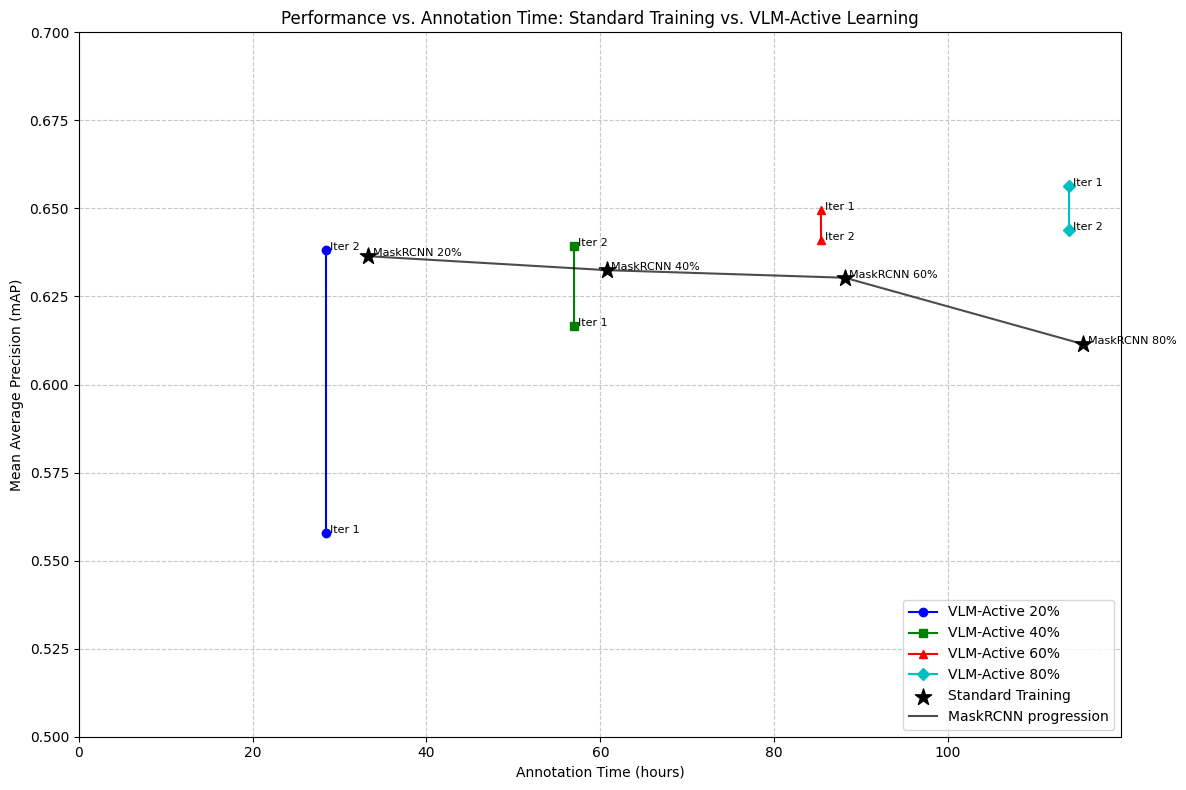

Annotation Time (hours) vs. mAP:

Standard Training (with binary feedback time):
MaskRCNN 20%: 33.3 hours → 0.6364 mAP
MaskRCNN 40%: 60.7 hours → 0.6325 mAP
MaskRCNN 60%: 88.1 hours → 0.6303 mAP
MaskRCNN 80%: 115.6 hours → 0.6115 mAP

VLM-Active Learning:

proportion_0.20:
  Base annotation time: 28.4 hours
  Iteration 1: 0.5579 mAP
  Iteration 2: 0.6381 mAP

proportion_0.40:
  Base annotation time: 57.0 hours
  Iteration 1: 0.6166 mAP
  Iteration 2: 0.6393 mAP

proportion_0.60:
  Base annotation time: 85.4 hours
  Iteration 1: 0.6496 mAP
  Iteration 2: 0.6410 mAP

proportion_0.80:
  Base annotation time: 113.9 hours
  Iteration 1: 0.6562 mAP
  Iteration 2: 0.6440 mAP


In [6]:
# For the first cell - fixed calculation including binary feedback time
import matplotlib.pyplot as plt
import json
import numpy as np

# Load experiment results
with open("maskrcnn_experiment_results.json") as f:
    maskrcnn_results = json.load(f)

with open("output_proportion_vlm_runs/proportions_exp_20250501_120307/experiment_summary.json") as f:
    active_learning_results = json.load(f)

# Dataset constants from statistics
TOTAL_TRAIN_IMAGES = 2792
AVG_INSTANCES_PER_IMAGE = 2.55
HUMAN_ANNOTATION_TIME = 80  # seconds per instance
BINARY_FEEDBACK_TIME = 3    # seconds per instance

# Set up the figure
plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y']
markers = ['o', 's', '^', 'D', 'v']

# Process standard MaskRCNN results (one point per proportion)
maskrcnn_times = []
maskrcnn_maps = []
maskrcnn_labels = []

# Sort the proportions to ensure proper progression
sorted_props_idx = np.argsort(maskrcnn_results["train_proportion"])
sorted_props = [maskrcnn_results["train_proportion"][i] for i in sorted_props_idx]
sorted_sizes = [maskrcnn_results["train_size"][i] for i in sorted_props_idx]
sorted_maps = [maskrcnn_results["mean_ap"][i] for i in sorted_props_idx]

# Calculate times with binary feedback for subsequent proportions
cumulative_time = 0
# Calculate times properly for each proportion
for i, prop in enumerate(sorted_props):
    train_size = sorted_sizes[i]
    map_score = sorted_maps[i]
    
    # Full annotation time for training images
    annotation_time = (train_size * AVG_INSTANCES_PER_IMAGE * HUMAN_ANNOTATION_TIME) / 3600
    
    # Binary feedback time for inference set (remaining images)
    inference_set_size = TOTAL_TRAIN_IMAGES - train_size
    binary_time = (inference_set_size * AVG_INSTANCES_PER_IMAGE * BINARY_FEEDBACK_TIME) / 3600
    
    # Total time is annotation + binary feedback
    time_hours = annotation_time + binary_time
    
    maskrcnn_times.append(time_hours)
    maskrcnn_maps.append(map_score)
    maskrcnn_labels.append(f"MaskRCNN {prop*100:.0f}%")

# Process active learning results (multiple iterations at same time point)
for i, (prop_key, results) in enumerate(active_learning_results.items()):
    prop = float(prop_key.split('_')[1])
    
    # Get initial training size and calculate time
    initial_train_size = results["train_size"][0]
    time_hours = (initial_train_size * AVG_INSTANCES_PER_IMAGE * HUMAN_ANNOTATION_TIME) / 3600
    
    # Plot all iterations at the same time point (vertical line)
    iterations = results["iteration"]
    map_scores = results["mean_ap"]
    
    plt.plot([time_hours] * len(iterations), map_scores, 
             marker=markers[i % len(markers)], 
             linestyle='-', 
             color=colors[i % len(colors)],
             label=f"VLM-Active {prop*100:.0f}%")
    
    # Add text annotations for each iteration
    for j, (iter_num, map_score) in enumerate(zip(iterations, map_scores)):
        plt.text(time_hours + 0.5, map_score, f"Iter {iter_num}", fontsize=8)

# Plot standard MaskRCNN points
plt.scatter(maskrcnn_times, maskrcnn_maps, marker='*', s=150, color='black', label="Standard Training")
for i, (time, map_score, label) in enumerate(zip(maskrcnn_times, maskrcnn_maps, maskrcnn_labels)):
    plt.text(time + 0.5, map_score, label, fontsize=8)

# Add a line connecting the MaskRCNN points
plt.plot(maskrcnn_times, maskrcnn_maps, 
         linestyle='-', 
         color='black',
         alpha=0.7,
         label="MaskRCNN progression")

# Update the legend to avoid duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
    elif label == "MaskRCNN progression":  # Keep this one and remove the single point label
        unique_labels[unique_labels.index("Standard Training")] = "MaskRCNN progression"
        unique_handles[unique_labels.index("MaskRCNN progression")] = handle

plt.legend(unique_handles, unique_labels, loc='lower right')

# Format plot
plt.xlabel('Annotation Time (hours)')
plt.ylabel('Mean Average Precision (mAP)')
plt.title('Performance vs. Annotation Time: Standard Training vs. VLM-Active Learning')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='lower right')

# Set reasonable axis limits
plt.xlim(left=0)
plt.ylim(0.5, 0.7)

plt.tight_layout()
plt.savefig('performance_vs_time_comparison.png', dpi=300)
plt.show()

# Print numeric analysis
print("Annotation Time (hours) vs. mAP:")
print("\nStandard Training (with binary feedback time):")
for time, map_score, label in zip(maskrcnn_times, maskrcnn_maps, maskrcnn_labels):
    print(f"{label}: {time:.1f} hours → {map_score:.4f} mAP")

print("\nVLM-Active Learning:")
for prop_key, results in active_learning_results.items():
    initial_train_size = results["train_size"][0]
    time_hours = (initial_train_size * AVG_INSTANCES_PER_IMAGE * HUMAN_ANNOTATION_TIME) / 3600
    
    print(f"\n{prop_key}:")
    print(f"  Base annotation time: {time_hours:.1f} hours")
    
    for iter_num, map_score in zip(results["iteration"], results["mean_ap"]):
        print(f"  Iteration {iter_num}: {map_score:.4f} mAP")